<a href="https://colab.research.google.com/github/victorialovefranklin/SEGDAMSBD566/blob/main/PCA_UMAP_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SEGDA: PCA and UMAP Dimensionality Reduction Analysis**


   SEGDA: Socio-Environmental Grid Disruption Analysis
   PCA and UMAP Dimensionality Reduction Pipeline


SEGDA DATA LOADING

Loading SVI data...
  ✓ Loaded 58 counties with 23 SVI variables
Loading CalEnviroScreen data...
  ✓ Loaded 58 counties with 25 CES variables
Loading NRI data...
  ✓ Loaded 58 counties with 15 NRI variables
Loading Storm Events data...
  ✓ Aggregated 183 events to 58 counties
Loading CAL FIRE data...
  ✓ Aggregated 69 fires to 27 counties
Loading Eagle-I outage data...
  ✓ Aggregated 146 outages to 58 counties
Loading county shapefile...
  ✓ Loaded 58 county geometries

------------------------------------------------------------
Data loading complete!
Loaded datasets: ['svi', 'ces', 'nri', 'storm', 'fire', 'outage', 'county_geo']
------------------------------------------------------------

Merging datasets...
  + SVI: (58, 26)
  + CES: (58, 51)
  + NRI: (58, 65)
  + Storm: (58, 75)
  + Fire: (58, 80)
  + Outage: (58, 89)

✓ Final merged dataset: 58 counties,

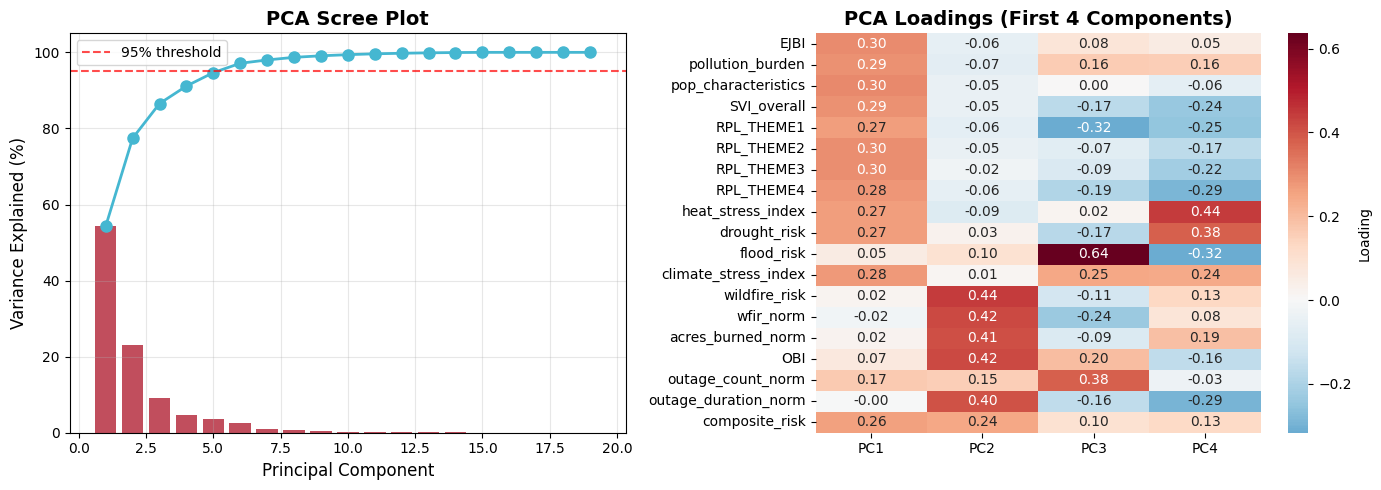

✓ Saved: segda_output/pca_biplot.png


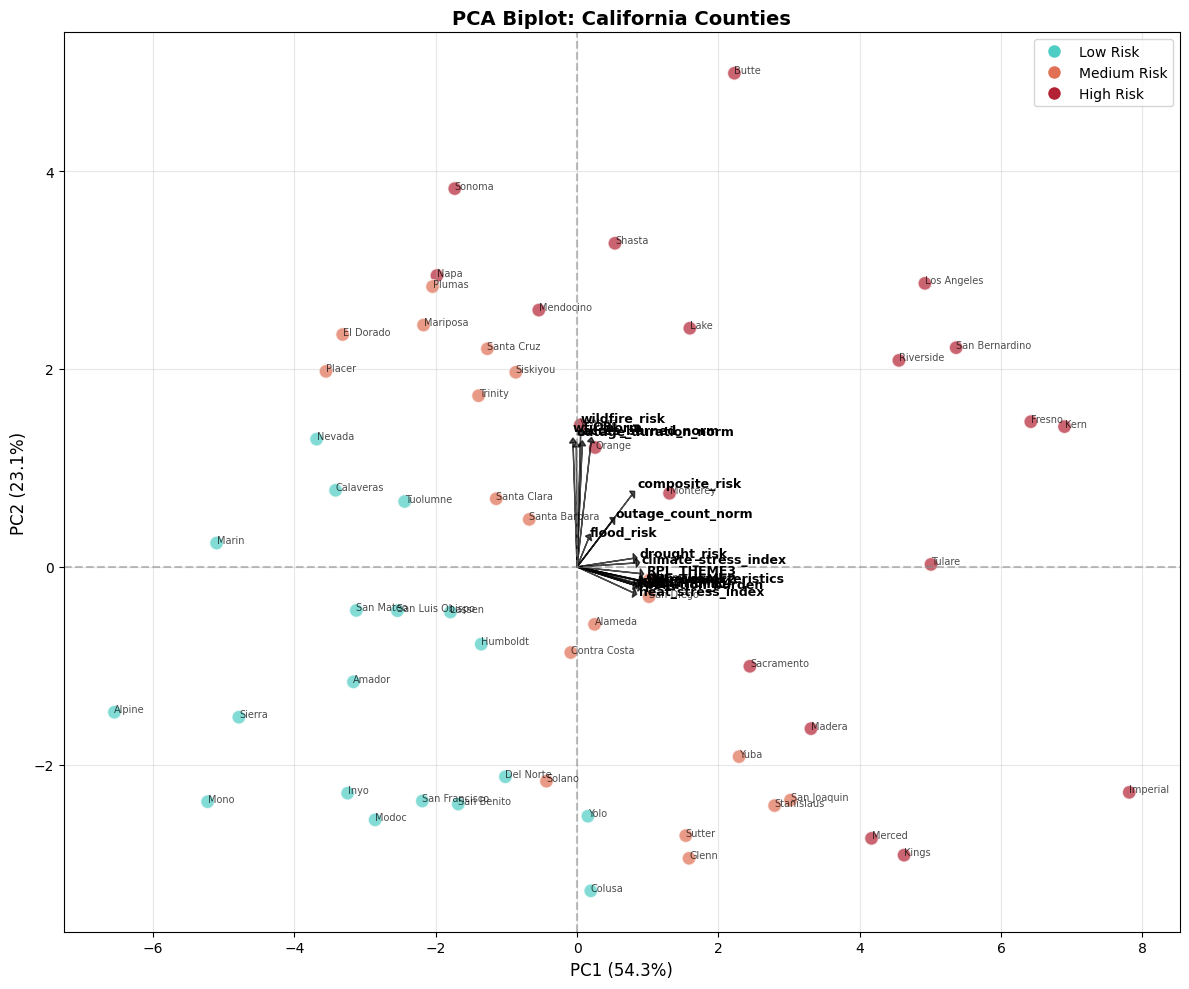


UMAP ANALYSIS

Fitting UMAP (n_neighbors=15, min_dist=0.1)...
✓ UMAP embedding shape: (58, 2)

Finding optimal clusters...
  K=2: Silhouette = 0.5521
  K=3: Silhouette = 0.4955
  K=4: Silhouette = 0.4370
  K=5: Silhouette = 0.4381
  K=6: Silhouette = 0.3748
  K=7: Silhouette = 0.4131
  K=8: Silhouette = 0.4211
  K=9: Silhouette = 0.4297

✓ Optimal K = 2 (Silhouette = 0.5521)

Applying K-Means with K=2...

Cluster Statistics:
--------------------------------------------------
  Cluster 0: 36 counties, Avg EJBI=0.333, Avg Risk=0.357
  Cluster 1: 22 counties, Avg EJBI=0.704, Avg Risk=0.497

Applying DBSCAN (eps=0.5, min_samples=3)...
✓ DBSCAN found 7 clusters and 5 noise points
✓ Saved: segda_output/umap_ejbi.png


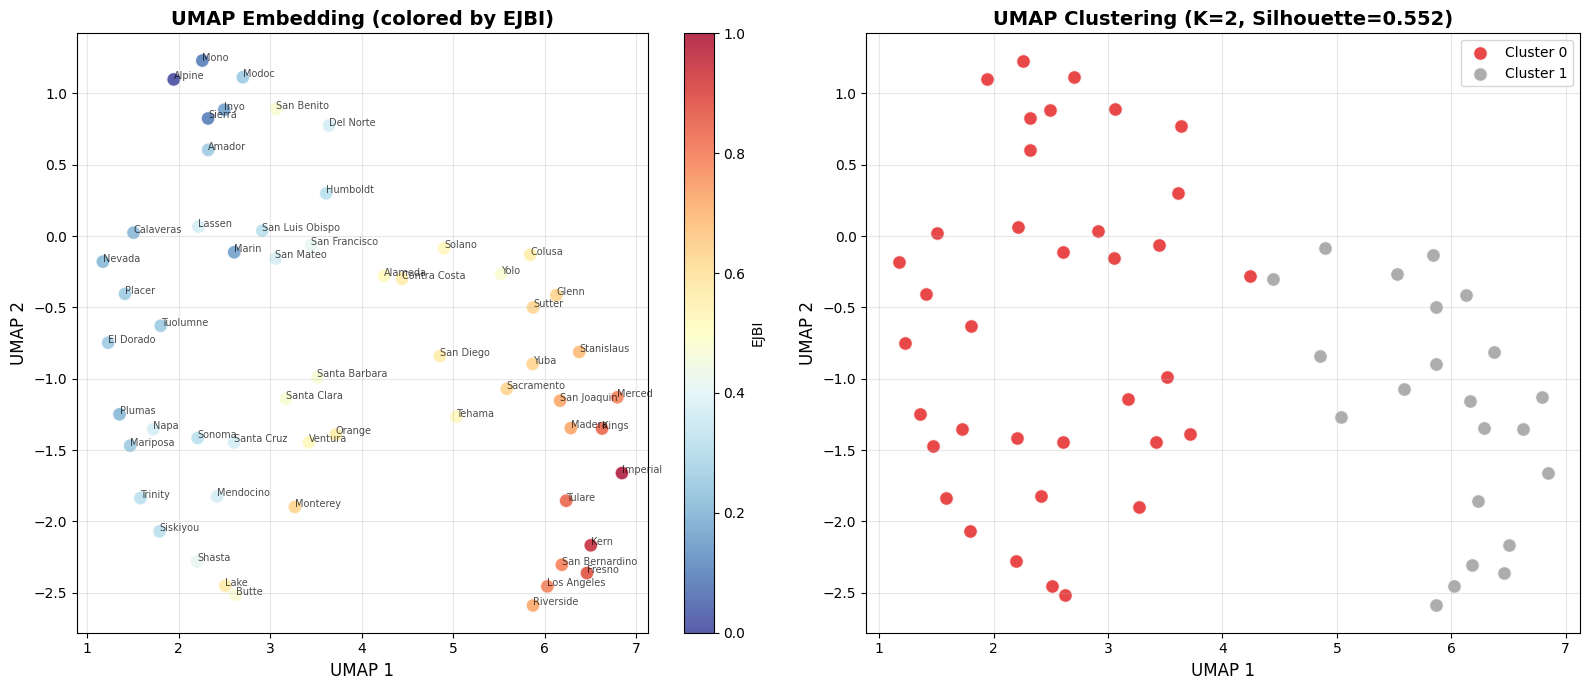

✓ Saved: segda_output/umap_vs_pca.png


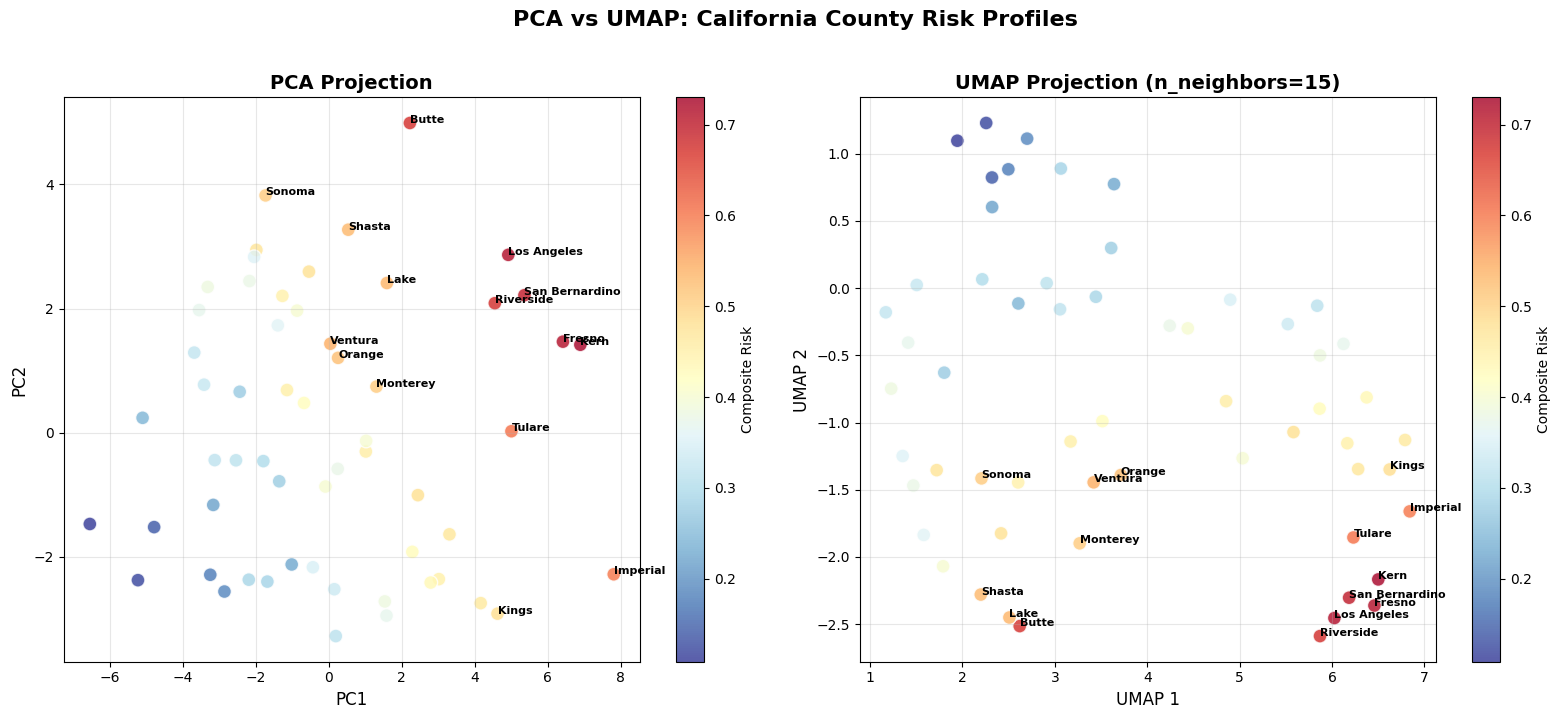

✓ Saved: segda_output/umap_6panel_risk.png


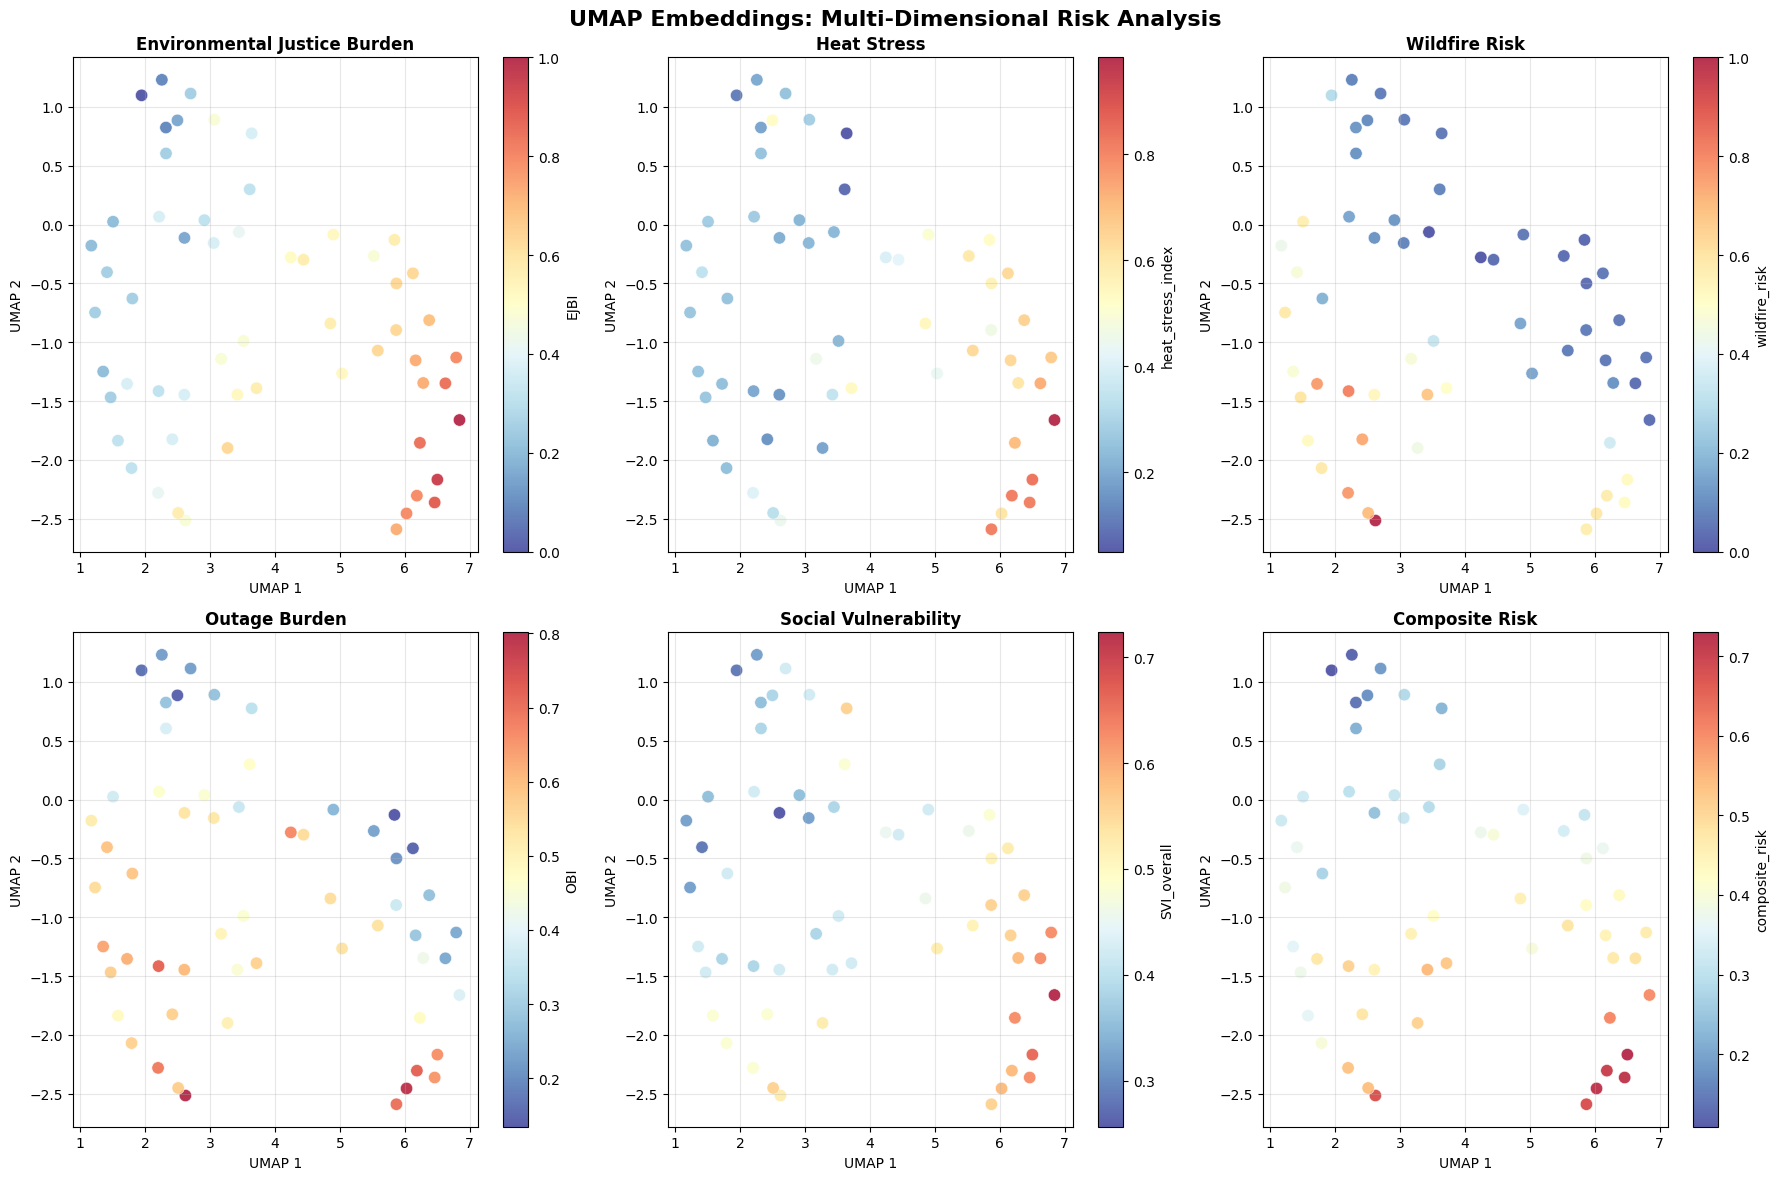


Cluster Profiles:
   cluster  n_counties                                                                                                                                                                                                                                                                                                                                               counties  avg_EJBI  avg_composite_risk  avg_heat_stress  avg_wildfire_risk   avg_OBI
0        0          36  [Sierra, Santa Barbara, Calaveras, Ventura, Sonoma, Placer, San Francisco, Marin, Mariposa, Lassen, Napa, Shasta, Monterey, Trinity, Mendocino, Inyo, Mono, Tuolumne, Alpine, El Dorado, San Benito, Humboldt, Del Norte, Modoc, Santa Clara, Alameda, Nevada, Butte, Orange, Amador, Lake, Plumas, San Mateo, Siskiyou, Santa Cruz, San Luis Obispo]  0.332750            0.357261         0.268026           0.377453  0.484160
1        1          22                                                                           

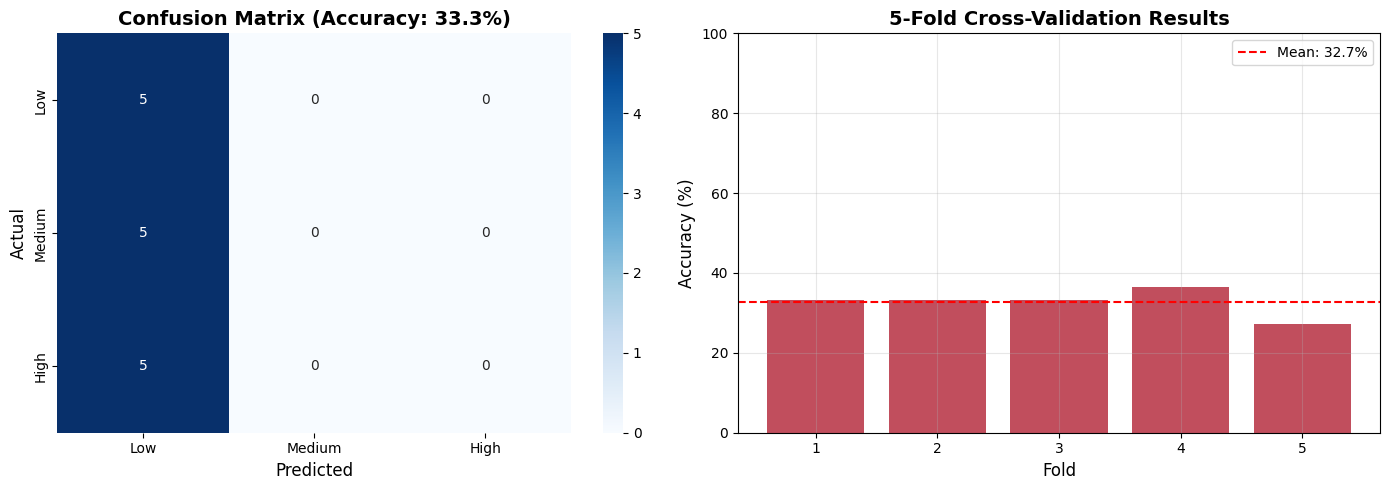


   ANALYSIS SUMMARY

📊 Dataset: 58 California counties
📊 Features: 19 variables

🔬 PCA Results:
   • Components for 95% variance: 6
   • PC1 variance: 54.29%
   • PC2 variance: 23.13%

🗺️ UMAP Results:
   • Optimal clusters: 2
   • Silhouette score: 0.5521

🤖 Neural Network Results:
   • Test accuracy: 33.33%
   • CV accuracy: 32.73% ± 2.97%

📁 Output files saved to: segda_output


In [2]:
#!/usr/bin/env python3
"""
================================================================================
SEGDA: PCA and UMAP Dimensionality Reduction Analysis
================================================================================
Comprehensive analysis integrating:
- Social Vulnerability Index (SVI)
- CalEnviroScreen 4.0
- FEMA National Risk Index (NRI)
- NOAA Storm Events
- CAL FIRE Incidents
- Eagle-I Outage Data
- EIA Energy Data
- County/Tract Shapefiles

Author: Victoria Love Franklin
Institution: Meharry Medical College
Date: December 2024
================================================================================
"""

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import requests
import json

# Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# UMAP
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    print("Warning: UMAP not installed. Install with: pip install umap-learn")
    UMAP_AVAILABLE = False

# Spatial Analysis
try:
    from libpysal.weights import KNN, Queen
    from esda.moran import Moran, Moran_Local
    SPATIAL_AVAILABLE = True
except ImportError:
    print("Warning: PySAL not installed. Spatial analysis limited.")
    SPATIAL_AVAILABLE = False

warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION
# =============================================================================

class Config:
    """Configuration settings for SEGDA analysis"""

    # File Paths (adjust for your environment)
    COUNTY_SHAPEFILE = "/content/tl_2023_us_county.shp"
    TRACT_SHAPEFILE = "/content/tl_2021_06_tract.shp"
    SVI_PATH = "/content/CA_svi_interactive_cleaned_fips.csv"
    CES_PATH = "/content/California_Environmental_Protection_Agency_clean.csv"
    NRI_PATH = "/content/NRI_Table_Counties_California.csv"
    STORM_PATH = "/content/ca_stormevents_county_month_eventtype_2010_2024.csv"
    FIRE_PATH = "/content/CALFIREIncidents_2013_2025_clean.csv"
    EAGLEI_PATH = "/content/eaglei_transformed.csv"

    # EIA API
    EIA_API_KEY = 'tN3xzmugnPVJ9Jtc8GTeiOIHKN1Fqw4ngR3sbDlU'
    EIA_BASE_URL = 'https://api.eia.gov/v2/'

    # Analysis Parameters
    RANDOM_STATE = 42
    PCA_VARIANCE_THRESHOLD = 0.95
    UMAP_N_NEIGHBORS = 15
    UMAP_MIN_DIST = 0.1
    KNN_K = 8

    # Composite Index Weights
    COMPOSITE_WEIGHTS = {
        'EJBI': 0.35,
        'climate': 0.25,
        'wildfire': 0.25,
        'OBI': 0.15
    }

    # Color Palettes
    SEGDA_COLORS = {
        'primary': '#B22234',
        'secondary': '#3C1414',
        'accent1': '#FF6B6B',
        'accent2': '#4ECDC4',
        'accent3': '#45B7D1',
        'neutral': '#636E72',
        'success': '#00B894',
        'warning': '#E17055'
    }

    LISA_COLORS = {
        'HH': '#d7191c',
        'LL': '#2c7bb6',
        'HL': '#fdae61',
        'LH': '#abd9e9',
        'NS': '#d3d3d3'
    }

    # California County FIPS
    CA_COUNTY_FIPS = {
        "Alameda": "06001", "Alpine": "06003", "Amador": "06005", "Butte": "06007",
        "Calaveras": "06009", "Colusa": "06011", "Contra Costa": "06013", "Del Norte": "06015",
        "El Dorado": "06017", "Fresno": "06019", "Glenn": "06021", "Humboldt": "06023",
        "Imperial": "06025", "Inyo": "06027", "Kern": "06029", "Kings": "06031",
        "Lake": "06033", "Lassen": "06035", "Los Angeles": "06037", "Madera": "06039",
        "Marin": "06041", "Mariposa": "06043", "Mendocino": "06045", "Merced": "06047",
        "Modoc": "06049", "Mono": "06051", "Monterey": "06053", "Napa": "06055",
        "Nevada": "06057", "Orange": "06059", "Placer": "06061", "Plumas": "06063",
        "Riverside": "06065", "Sacramento": "06067", "San Benito": "06069",
        "San Bernardino": "06071", "San Diego": "06073", "San Francisco": "06075",
        "San Joaquin": "06077", "San Luis Obispo": "06079", "San Mateo": "06081",
        "Santa Barbara": "06083", "Santa Clara": "06085", "Santa Cruz": "06087",
        "Shasta": "06089", "Sierra": "06091", "Siskiyou": "06093", "Solano": "06095",
        "Sonoma": "06097", "Stanislaus": "06099", "Sutter": "06101", "Tehama": "06103",
        "Trinity": "06105", "Tulare": "06107", "Tuolumne": "06109", "Ventura": "06111",
        "Yolo": "06113", "Yuba": "06115"
    }

    # Regional Classification
    CA_REGIONS = {
        "North Coast": ["Del Norte", "Humboldt", "Mendocino"],
        "North Interior": ["Siskiyou", "Modoc", "Lassen", "Shasta", "Trinity",
                           "Tehama", "Plumas", "Butte", "Glenn", "Colusa"],
        "Bay Area": ["Sonoma", "Napa", "Marin", "San Francisco", "San Mateo",
                     "Santa Clara", "Alameda", "Contra Costa", "Solano"],
        "Central Coast": ["Santa Cruz", "Monterey", "San Benito", "San Luis Obispo",
                          "Santa Barbara"],
        "Central Valley": ["Sacramento", "Yolo", "San Joaquin", "Stanislaus",
                           "Merced", "Madera", "Fresno", "Kings", "Tulare", "Kern"],
        "Sierra": ["Nevada", "Placer", "El Dorado", "Amador", "Calaveras",
                   "Tuolumne", "Mariposa", "Alpine", "Mono", "Inyo", "Sierra",
                   "Yuba", "Sutter"],
        "South Coast": ["Ventura", "Los Angeles", "Orange"],
        "Inland Empire": ["Riverside", "San Bernardino"],
        "Desert": ["Imperial", "San Diego"]
    }

    # Heat Stress Data (pre-computed)
    COUNTY_HEAT_STRESS = {
        "Imperial": 0.95, "Fresno": 0.85, "Kern": 0.85, "Kings": 0.85, "Riverside": 0.85,
        "Tulare": 0.82, "San Bernardino": 0.80, "Madera": 0.78, "Merced": 0.78,
        "Sacramento": 0.77, "Los Angeles": 0.65, "San Diego": 0.50, "Orange": 0.48,
        "Santa Clara": 0.53, "Alameda": 0.48, "San Francisco": 0.27, "Humboldt": 0.20,
        "Del Norte": 0.15, "Tehama": 0.78, "Glenn": 0.77, "Stanislaus": 0.77,
        "Shasta": 0.76, "Inyo": 0.75, "Sutter": 0.75, "Butte": 0.75, "Colusa": 0.75,
        "San Joaquin": 0.73, "Yolo": 0.72, "Yuba": 0.72, "Mariposa": 0.58, "Lake": 0.58,
        "Calaveras": 0.57, "Tuolumne": 0.55, "Amador": 0.55, "Modoc": 0.55,
        "Placer": 0.52, "Lassen": 0.52, "Contra Costa": 0.50, "Nevada": 0.50,
        "El Dorado": 0.48, "Siskiyou": 0.48, "Solano": 0.48, "Trinity": 0.45,
        "San Benito": 0.45, "Mono": 0.45, "Plumas": 0.45, "Napa": 0.43, "Ventura": 0.43,
        "Sierra": 0.42, "Santa Barbara": 0.38, "San Luis Obispo": 0.37, "Sonoma": 0.32,
        "Monterey": 0.30, "Alpine": 0.28, "Marin": 0.28, "Santa Cruz": 0.28,
        "San Mateo": 0.27, "Mendocino": 0.25
    }


# =============================================================================
# DATA LOADING FUNCTIONS
# =============================================================================

class DataLoader:
    """Load and preprocess all data sources"""

    def __init__(self, config=Config):
        self.config = config
        self.data = {}

    def standardize_county_name(self, name):
        """Standardize county names for joining"""
        if pd.isna(name):
            return None
        name = str(name).strip().title()
        name = name.replace(' County', '')
        # Handle special cases
        replacements = {
            'San Buenaventura (Ventura)': 'Ventura',
            'Sanbernardino': 'San Bernardino',
            'Sanfrancisco': 'San Francisco',
            'Losangeles': 'Los Angeles',
            'Sandiego': 'San Diego'
        }
        return replacements.get(name, name)

    def load_svi(self):
        """Load Social Vulnerability Index data"""
        print("Loading SVI data...")
        try:
            df = pd.read_csv(self.config.SVI_PATH)
            df['county_std'] = df['county'].apply(self.standardize_county_name)

            # Select key columns
            svi_cols = ['county_std', 'FIPS', 'E_TOTPOP',
                        'EP_POV150', 'EP_UNEMP', 'EP_HBURD', 'EP_NOHSDP', 'EP_UNINSUR',
                        'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_LIMENG',
                        'EP_MINRTY', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH',
                        'RPL_THEMES', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4']

            available_cols = [c for c in svi_cols if c in df.columns]
            df = df[available_cols].copy()

            print(f"  ✓ Loaded {len(df)} counties with {len(available_cols)} SVI variables")
            self.data['svi'] = df
            return df
        except Exception as e:
            print(f"  ✗ Error loading SVI: {e}")
            return None

    def load_calenviroscreen(self):
        """Load CalEnviroScreen 4.0 data"""
        print("Loading CalEnviroScreen data...")
        try:
            df = pd.read_csv(self.config.CES_PATH)
            df['county_std'] = df['county'].apply(self.standardize_county_name)

            # Rename columns for clarity
            rename_map = {
                'CIscore': 'ces_score',
                'CIscorePctl': 'ces_percentile',
                'Pollution_Burden': 'pollution_burden',
                'Pop_Characteristics': 'pop_characteristics'
            }
            df = df.rename(columns=rename_map)

            print(f"  ✓ Loaded {len(df)} counties with {len(df.columns)-1} CES variables")
            self.data['ces'] = df
            return df
        except Exception as e:
            print(f"  ✗ Error loading CalEnviroScreen: {e}")
            return None

    def load_nri(self):
        """Load FEMA National Risk Index data"""
        print("Loading NRI data...")
        try:
            df = pd.read_csv(self.config.NRI_PATH)
            df['county_std'] = df['COUNTY'].apply(self.standardize_county_name)

            # Select key risk columns
            nri_cols = ['county_std', 'STCOFIPS', 'RISK_SCORE', 'RISK_RATNG',
                        'EAL_SCORE', 'SOVI_SCORE', 'RESL_SCORE',
                        'DRGT_RISKS', 'HWAV_RISKS', 'WFIR_RISKS', 'SWND_RISKS',
                        'RFLD_RISKS', 'CFLD_RISKS', 'ERQK_RISKS', 'TRND_RISKS']

            available_cols = [c for c in nri_cols if c in df.columns]
            df = df[available_cols].copy()

            print(f"  ✓ Loaded {len(df)} counties with {len(available_cols)} NRI variables")
            self.data['nri'] = df
            return df
        except Exception as e:
            print(f"  ✗ Error loading NRI: {e}")
            return None

    def load_storm_events(self):
        """Load and aggregate NOAA Storm Events data"""
        print("Loading Storm Events data...")
        try:
            df = pd.read_csv(self.config.STORM_PATH)
            df['county_std'] = df['county'].apply(self.standardize_county_name)

            # Aggregate by county
            agg_df = df.groupby('county_std').agg({
                'INJURIES_DIRECT': 'sum',
                'DEATHS_DIRECT': 'sum',
                'DAMAGE_PROPERTY': 'sum'
            }).reset_index()

            agg_df.columns = ['county_std', 'storm_injuries', 'storm_deaths', 'storm_damage']

            # Count events by type
            event_types = ['Heat', 'Excessive Heat', 'Wildfire', 'Flood', 'Winter Storm', 'Heavy Rain']
            for event_type in event_types:
                event_name = event_type.lower().replace(' ', '_') + '_count'
                counts = df[df['EVENT_TYPE'] == event_type].groupby('county_std').size()
                agg_df[event_name] = agg_df['county_std'].map(counts).fillna(0).astype(int)

            # Combined heat events
            agg_df['heat_event_count'] = agg_df['heat_count'] + agg_df['excessive_heat_count']

            print(f"  ✓ Aggregated {len(df)} events to {len(agg_df)} counties")
            self.data['storm'] = agg_df
            return agg_df
        except Exception as e:
            print(f"  ✗ Error loading Storm Events: {e}")
            return None

    def load_calfire(self):
        """Load and aggregate CAL FIRE incidents"""
        print("Loading CAL FIRE data...")
        try:
            df = pd.read_csv(self.config.FIRE_PATH)
            df['county_std'] = df['Counties'].apply(self.standardize_county_name)

            # Aggregate by county
            agg_df = df.groupby('county_std').agg({
                'incident_acres_burned': ['sum', 'max', 'count'],
                'fatalities': 'sum',
                'structures_destroyed': 'sum'
            }).reset_index()

            agg_df.columns = ['county_std', 'total_acres_burned', 'max_fire_acres',
                              'fire_incident_count', 'fire_fatalities', 'structures_destroyed']

            print(f"  ✓ Aggregated {len(df)} fires to {len(agg_df)} counties")
            self.data['fire'] = agg_df
            return agg_df
        except Exception as e:
            print(f"  ✗ Error loading CAL FIRE: {e}")
            return None

    def load_eaglei(self):
        """Load and aggregate Eagle-I outage data"""
        print("Loading Eagle-I outage data...")
        try:
            df = pd.read_csv(self.config.EAGLEI_PATH)
            df['county_std'] = df['county'].apply(self.standardize_county_name)

            # Aggregate by county
            agg_df = df.groupby('county_std').agg({
                'duration': ['count', 'sum', 'mean', 'max'],
                'max_customers': ['max', 'sum', 'mean'],
                'hours': 'sum'
            }).reset_index()

            agg_df.columns = ['county_std', 'outage_count', 'total_outage_duration',
                              'avg_outage_duration', 'max_outage_duration',
                              'max_customers_affected', 'total_customers_affected',
                              'avg_customers_affected', 'total_outage_hours']

            # Calculate SAIDI proxy (customer-hours)
            agg_df['customer_hours'] = agg_df['total_outage_hours'] * agg_df['avg_customers_affected']

            print(f"  ✓ Aggregated {len(df)} outages to {len(agg_df)} counties")
            self.data['outage'] = agg_df
            return agg_df
        except Exception as e:
            print(f"  ✗ Error loading Eagle-I: {e}")
            return None

    def load_shapefile(self, level='county'):
        """Load county or tract shapefile"""
        print(f"Loading {level} shapefile...")
        try:
            if level == 'county':
                gdf = gpd.read_file(self.config.COUNTY_SHAPEFILE)
                gdf = gdf[gdf['STATEFP'] == '06'].copy()
                gdf['county_std'] = gdf['NAME'].apply(self.standardize_county_name)
                gdf = gdf[['GEOID', 'NAME', 'county_std', 'geometry']].copy()
                gdf.columns = ['fips', 'county_name', 'county_std', 'geometry']
            else:
                gdf = gpd.read_file(self.config.TRACT_SHAPEFILE)
                gdf = gdf[['GEOID', 'NAME', 'geometry']].copy()

            print(f"  ✓ Loaded {len(gdf)} {level} geometries")
            self.data[f'{level}_geo'] = gdf
            return gdf
        except Exception as e:
            print(f"  ✗ Error loading shapefile: {e}")
            return None

    def fetch_eia_data(self):
        """Fetch EIA energy data via API"""
        print("Fetching EIA data...")
        try:
            # State-level California electricity generation
            url = f"{self.config.EIA_BASE_URL}electricity/state-electricity-profiles/source-disposition/data/"
            params = {
                'api_key': self.config.EIA_API_KEY,
                'frequency': 'annual',
                'data[0]': 'generation',
                'facets[state][]': 'CA',
                'sort[0][column]': 'period',
                'sort[0][direction]': 'desc',
                'length': 100
            }

            response = requests.get(url, params=params)
            if response.status_code == 200:
                data = response.json()
                if 'response' in data and 'data' in data['response']:
                    eia_df = pd.DataFrame(data['response']['data'])
                    print(f"  ✓ Fetched {len(eia_df)} EIA records")
                    self.data['eia'] = eia_df
                    return eia_df
            print(f"  ⚠ EIA API returned status {response.status_code}")
            return None
        except Exception as e:
            print(f"  ✗ Error fetching EIA data: {e}")
            return None

    def load_all(self):
        """Load all data sources"""
        print("\n" + "="*60)
        print("SEGDA DATA LOADING")
        print("="*60 + "\n")

        self.load_svi()
        self.load_calenviroscreen()
        self.load_nri()
        self.load_storm_events()
        self.load_calfire()
        self.load_eaglei()
        self.load_shapefile('county')
        # self.fetch_eia_data()  # Uncomment if API access available

        print("\n" + "-"*60)
        print("Data loading complete!")
        print(f"Loaded datasets: {list(self.data.keys())}")
        print("-"*60 + "\n")

        return self.data


# =============================================================================
# DATA INTEGRATION
# =============================================================================

class DataIntegrator:
    """Merge all data sources into unified analysis dataset"""

    def __init__(self, data_dict, config=Config):
        self.data = data_dict
        self.config = config
        self.merged = None

    def merge_all(self):
        """Merge all datasets on county"""
        print("Merging datasets...")

        # Start with county geography
        if 'county_geo' in self.data:
            merged = self.data['county_geo'].copy()
        else:
            # Create base from FIPS
            merged = pd.DataFrame({
                'county_std': list(self.config.CA_COUNTY_FIPS.keys()),
                'fips': list(self.config.CA_COUNTY_FIPS.values())
            })

        # Merge SVI
        if 'svi' in self.data:
            merged = merged.merge(self.data['svi'], on='county_std', how='left', suffixes=('', '_svi'))
            print(f"  + SVI: {merged.shape}")

        # Merge CalEnviroScreen
        if 'ces' in self.data:
            merged = merged.merge(self.data['ces'], on='county_std', how='left', suffixes=('', '_ces'))
            print(f"  + CES: {merged.shape}")

        # Merge NRI
        if 'nri' in self.data:
            merged = merged.merge(self.data['nri'], on='county_std', how='left', suffixes=('', '_nri'))
            print(f"  + NRI: {merged.shape}")

        # Merge Storm Events
        if 'storm' in self.data:
            merged = merged.merge(self.data['storm'], on='county_std', how='left', suffixes=('', '_storm'))
            print(f"  + Storm: {merged.shape}")

        # Merge CAL FIRE
        if 'fire' in self.data:
            merged = merged.merge(self.data['fire'], on='county_std', how='left', suffixes=('', '_fire'))
            print(f"  + Fire: {merged.shape}")

        # Merge Eagle-I
        if 'outage' in self.data:
            merged = merged.merge(self.data['outage'], on='county_std', how='left', suffixes=('', '_outage'))
            print(f"  + Outage: {merged.shape}")

        # Add heat stress from config
        merged['heat_stress_config'] = merged['county_std'].map(self.config.COUNTY_HEAT_STRESS)

        # Add region
        county_to_region = {c: r for r, counties in self.config.CA_REGIONS.items() for c in counties}
        merged['region'] = merged['county_std'].map(county_to_region)

        print(f"\n✓ Final merged dataset: {merged.shape[0]} counties, {merged.shape[1]} columns")

        self.merged = merged
        return merged

    def create_indices(self):
        """Create normalized composite indices"""
        print("\nCreating composite indices...")

        if self.merged is None:
            self.merge_all()

        df = self.merged.copy()

        # Helper functions
        def min_max_norm(series):
            s = pd.to_numeric(series, errors='coerce')
            if s.max() == s.min():
                return pd.Series(0, index=series.index)
            return (s - s.min()) / (s.max() - s.min())

        def log_min_max_norm(series):
            s = pd.to_numeric(series, errors='coerce').fillna(0)
            log_s = np.log1p(s)
            return min_max_norm(log_s)

        # ===================
        # EJBI (Environmental Justice Burden Index)
        # ===================
        if 'ces_score' in df.columns:
            df['EJBI'] = min_max_norm(df['ces_score'])
        elif 'CIscore' in df.columns:
            df['EJBI'] = min_max_norm(df['CIscore'])
        else:
            df['EJBI'] = 0.5  # Default
        print(f"  ✓ EJBI: mean={df['EJBI'].mean():.3f}")

        # ===================
        # SVI Composite
        # ===================
        if 'RPL_THEMES' in df.columns:
            df['SVI_overall'] = df['RPL_THEMES']
        else:
            df['SVI_overall'] = 0.5
        print(f"  ✓ SVI: mean={df['SVI_overall'].mean():.3f}")

        # ===================
        # Heat Stress Index
        # ===================
        heat_cols = []
        if 'heat_event_count' in df.columns:
            df['heat_events_norm'] = min_max_norm(df['heat_event_count'])
            heat_cols.append('heat_events_norm')
        if 'HWAV_RISKS' in df.columns:
            df['hwav_norm'] = min_max_norm(df['HWAV_RISKS'])
            heat_cols.append('hwav_norm')
        if 'heat_stress_config' in df.columns:
            heat_cols.append('heat_stress_config')

        if heat_cols:
            df['heat_stress_index'] = df[heat_cols].mean(axis=1)
        else:
            df['heat_stress_index'] = 0.5
        print(f"  ✓ Heat Stress: mean={df['heat_stress_index'].mean():.3f}")

        # ===================
        # Drought Risk
        # ===================
        if 'DRGT_RISKS' in df.columns:
            df['drought_risk'] = min_max_norm(df['DRGT_RISKS'])
        else:
            df['drought_risk'] = 0.5
        print(f"  ✓ Drought: mean={df['drought_risk'].mean():.3f}")

        # ===================
        # Flood Risk Composite
        # ===================
        flood_cols = []
        if 'RFLD_RISKS' in df.columns:
            df['rfld_norm'] = min_max_norm(df['RFLD_RISKS'])
            flood_cols.append('rfld_norm')
        if 'CFLD_RISKS' in df.columns:
            df['cfld_norm'] = min_max_norm(df['CFLD_RISKS'])
            flood_cols.append('cfld_norm')
        if 'flood_count' in df.columns:
            df['flood_events_norm'] = min_max_norm(df['flood_count'])
            flood_cols.append('flood_events_norm')

        if flood_cols:
            df['flood_risk'] = df[flood_cols].mean(axis=1)
        else:
            df['flood_risk'] = 0.5
        print(f"  ✓ Flood: mean={df['flood_risk'].mean():.3f}")

        # ===================
        # Climate Stress Composite
        # ===================
        df['climate_stress_index'] = (
            0.40 * df['heat_stress_index'] +
            0.30 * df['drought_risk'] +
            0.30 * df['flood_risk']
        )
        print(f"  ✓ Climate Composite: mean={df['climate_stress_index'].mean():.3f}")

        # ===================
        # Wildfire Risk Composite
        # ===================
        wildfire_cols = []
        if 'total_acres_burned' in df.columns:
            df['acres_burned_norm'] = log_min_max_norm(df['total_acres_burned'].fillna(0))
            wildfire_cols.append('acres_burned_norm')
        if 'structures_destroyed' in df.columns:
            df['structures_norm'] = log_min_max_norm(df['structures_destroyed'].fillna(0))
            wildfire_cols.append('structures_norm')
        if 'WFIR_RISKS' in df.columns:
            df['wfir_norm'] = min_max_norm(df['WFIR_RISKS'])
            wildfire_cols.append('wfir_norm')
        if 'fire_fatalities' in df.columns:
            df['fire_fatal_norm'] = log_min_max_norm(df['fire_fatalities'].fillna(0))
            wildfire_cols.append('fire_fatal_norm')

        if wildfire_cols:
            df['wildfire_risk'] = df[wildfire_cols].mean(axis=1)
        else:
            df['wildfire_risk'] = 0.5
        print(f"  ✓ Wildfire: mean={df['wildfire_risk'].mean():.3f}")

        # ===================
        # OBI (Outage Burden Index)
        # ===================
        obi_cols = []
        if 'outage_count' in df.columns:
            df['outage_count_norm'] = min_max_norm(df['outage_count'].fillna(0))
            obi_cols.append('outage_count_norm')
        if 'total_outage_duration' in df.columns:
            df['outage_duration_norm'] = log_min_max_norm(df['total_outage_duration'].fillna(0))
            obi_cols.append('outage_duration_norm')
        if 'max_customers_affected' in df.columns:
            df['outage_customers_norm'] = log_min_max_norm(df['max_customers_affected'].fillna(0))
            obi_cols.append('outage_customers_norm')
        if 'storm_damage' in df.columns:
            df['storm_damage_norm'] = log_min_max_norm(df['storm_damage'].fillna(0))
            obi_cols.append('storm_damage_norm')

        if obi_cols:
            df['OBI'] = df[obi_cols].mean(axis=1)
        else:
            df['OBI'] = 0.5
        print(f"  ✓ OBI: mean={df['OBI'].mean():.3f}")

        # ===================
        # Composite Risk Score
        # ===================
        w = self.config.COMPOSITE_WEIGHTS
        df['composite_risk'] = (
            w['EJBI'] * df['EJBI'] +
            w['climate'] * df['climate_stress_index'] +
            w['wildfire'] * df['wildfire_risk'] +
            w['OBI'] * df['OBI']
        )
        print(f"  ✓ Composite Risk: mean={df['composite_risk'].mean():.3f}")

        # ===================
        # Risk Category
        # ===================
        df['risk_category'] = pd.qcut(
            df['composite_risk'],
            q=3,
            labels=['Low', 'Medium', 'High']
        )
        print(f"  ✓ Risk Categories: {df['risk_category'].value_counts().to_dict()}")

        self.merged = df
        return df


# =============================================================================
# PCA ANALYSIS
# =============================================================================

class PCAAnalysis:
    """Principal Component Analysis for dimensionality reduction"""

    def __init__(self, data, config=Config):
        self.data = data
        self.config = config
        self.features = None
        self.feature_names = None
        self.scaler = None
        self.pca = None
        self.pca_results = None

    def select_features(self):
        """Select features for PCA"""
        # Define feature groups
        feature_candidates = {
            # Environmental Justice
            'EJBI': 'EJBI',
            'pollution_burden': 'pollution_burden',
            'pop_characteristics': 'pop_characteristics',

            # Social Vulnerability
            'SVI_overall': 'SVI_overall',
            'RPL_THEME1': 'RPL_THEME1',
            'RPL_THEME2': 'RPL_THEME2',
            'RPL_THEME3': 'RPL_THEME3',
            'RPL_THEME4': 'RPL_THEME4',

            # Climate Stress
            'heat_stress_index': 'heat_stress_index',
            'drought_risk': 'drought_risk',
            'flood_risk': 'flood_risk',
            'climate_stress_index': 'climate_stress_index',

            # Wildfire
            'wildfire_risk': 'wildfire_risk',
            'wfir_norm': 'wfir_norm',
            'acres_burned_norm': 'acres_burned_norm',

            # Grid/Outage
            'OBI': 'OBI',
            'outage_count_norm': 'outage_count_norm',
            'outage_duration_norm': 'outage_duration_norm',

            # Composite
            'composite_risk': 'composite_risk'
        }

        # Select available features
        available = []
        for col, name in feature_candidates.items():
            if col in self.data.columns:
                available.append(col)

        self.feature_names = available
        print(f"Selected {len(available)} features for PCA:")
        for f in available:
            print(f"  • {f}")

        return available

    def prepare_data(self):
        """Prepare and scale data for PCA"""
        if self.feature_names is None:
            self.select_features()

        # Extract features
        X = self.data[self.feature_names].copy()

        # Handle missing values
        X = X.fillna(X.median())

        # Standardize
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        self.features = X_scaled
        return X_scaled

    def fit_pca(self, n_components=None):
        """Fit PCA model"""
        print("\n" + "="*60)
        print("PCA ANALYSIS")
        print("="*60)

        if self.features is None:
            self.prepare_data()

        # Fit PCA
        self.pca = PCA(n_components=n_components)
        pca_scores = self.pca.fit_transform(self.features)

        # Results
        explained_var = self.pca.explained_variance_ratio_
        cumulative_var = np.cumsum(explained_var)

        print(f"\nVariance Explained:")
        print("-" * 50)
        for i, (var, cum) in enumerate(zip(explained_var, cumulative_var)):
            print(f"  PC{i+1}: {var*100:.2f}% (Cumulative: {cum*100:.2f}%)")
            if cum >= self.config.PCA_VARIANCE_THRESHOLD:
                self.n_components_95 = i + 1
                break

        print(f"\n✓ Components for 95% variance: {self.n_components_95}")

        # Store results
        self.pca_results = {
            'scores': pca_scores,
            'loadings': self.pca.components_,
            'explained_variance': explained_var,
            'cumulative_variance': cumulative_var,
            'n_components_95': self.n_components_95
        }

        return self.pca_results

    def get_loadings_df(self):
        """Get loadings as DataFrame"""
        loadings_df = pd.DataFrame(
            self.pca.components_.T,
            columns=[f'PC{i+1}' for i in range(self.pca.n_components_)],
            index=self.feature_names
        )
        return loadings_df

    def interpret_components(self):
        """Interpret principal components"""
        print("\nComponent Interpretation:")
        print("-" * 50)

        loadings = self.get_loadings_df()

        for pc in loadings.columns[:4]:
            print(f"\n{pc}:")
            top_pos = loadings[pc].nlargest(3)
            top_neg = loadings[pc].nsmallest(3)

            print("  Positive loadings:")
            for feat, val in top_pos.items():
                print(f"    {feat}: {val:.3f}")
            print("  Negative loadings:")
            for feat, val in top_neg.items():
                print(f"    {feat}: {val:.3f}")

        return loadings

    def plot_variance(self, save_path=None):
        """Plot variance explained"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Scree plot
        ax1 = axes[0]
        n_comp = len(self.pca_results['explained_variance'])
        ax1.bar(range(1, n_comp+1), self.pca_results['explained_variance']*100,
                color=self.config.SEGDA_COLORS['primary'], alpha=0.8)
        ax1.plot(range(1, n_comp+1), self.pca_results['cumulative_variance']*100,
                 'o-', color=self.config.SEGDA_COLORS['accent3'], linewidth=2, markersize=8)
        ax1.axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
        ax1.set_xlabel('Principal Component', fontsize=12)
        ax1.set_ylabel('Variance Explained (%)', fontsize=12)
        ax1.set_title('PCA Scree Plot', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Loadings heatmap
        ax2 = axes[1]
        loadings = self.get_loadings_df().iloc[:, :4]
        sns.heatmap(loadings, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                    ax=ax2, cbar_kws={'label': 'Loading'})
        ax2.set_title('PCA Loadings (First 4 Components)', fontsize=14, fontweight='bold')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved: {save_path}")

        plt.show()
        return fig

    def plot_biplot(self, save_path=None):
        """Create PCA biplot"""
        fig, ax = plt.subplots(figsize=(12, 10))

        scores = self.pca_results['scores']
        loadings = self.pca.components_

        # Color by risk category if available
        if 'risk_category' in self.data.columns:
            colors = self.data['risk_category'].map({
                'Low': self.config.SEGDA_COLORS['accent2'],
                'Medium': self.config.SEGDA_COLORS['warning'],
                'High': self.config.SEGDA_COLORS['primary']
            })
        else:
            colors = self.config.SEGDA_COLORS['neutral']

        # Plot scores
        scatter = ax.scatter(scores[:, 0], scores[:, 1], c=colors, s=100, alpha=0.7, edgecolors='white')

        # Add county labels
        if 'county_std' in self.data.columns:
            for i, county in enumerate(self.data['county_std']):
                ax.annotate(county, (scores[i, 0], scores[i, 1]), fontsize=7, alpha=0.7)

        # Plot loadings as arrows
        scale = 3
        for i, feature in enumerate(self.feature_names):
            ax.arrow(0, 0, loadings[0, i]*scale, loadings[1, i]*scale,
                     color='black', alpha=0.7, head_width=0.1, head_length=0.05)
            ax.text(loadings[0, i]*scale*1.1, loadings[1, i]*scale*1.1,
                    feature, fontsize=9, fontweight='bold')

        # Formatting
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        ax.set_xlabel(f'PC1 ({self.pca_results["explained_variance"][0]*100:.1f}%)', fontsize=12)
        ax.set_ylabel(f'PC2 ({self.pca_results["explained_variance"][1]*100:.1f}%)', fontsize=12)
        ax.set_title('PCA Biplot: California Counties', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        # Legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor=self.config.SEGDA_COLORS['accent2'], markersize=10, label='Low Risk'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=self.config.SEGDA_COLORS['warning'], markersize=10, label='Medium Risk'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=self.config.SEGDA_COLORS['primary'], markersize=10, label='High Risk')
        ]
        ax.legend(handles=legend_elements, loc='upper right')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved: {save_path}")

        plt.show()
        return fig


# =============================================================================
# UMAP ANALYSIS
# =============================================================================

class UMAPAnalysis:
    """UMAP dimensionality reduction and clustering"""

    def __init__(self, data, features, feature_names, config=Config):
        self.data = data
        self.features = features
        self.feature_names = feature_names
        self.config = config
        self.umap_model = None
        self.umap_embedding = None
        self.umap_3d = None
        self.cluster_labels = None
        self.best_k = None

    def fit_umap(self, n_components=2):
        """Fit UMAP model"""
        print("\n" + "="*60)
        print("UMAP ANALYSIS")
        print("="*60)

        if not UMAP_AVAILABLE:
            print("✗ UMAP not available. Install with: pip install umap-learn")
            return None

        print(f"\nFitting UMAP (n_neighbors={self.config.UMAP_N_NEIGHBORS}, min_dist={self.config.UMAP_MIN_DIST})...")

        self.umap_model = umap.UMAP(
            n_neighbors=self.config.UMAP_N_NEIGHBORS,
            min_dist=self.config.UMAP_MIN_DIST,
            n_components=n_components,
            metric='euclidean',
            random_state=self.config.RANDOM_STATE
        )

        self.umap_embedding = self.umap_model.fit_transform(self.features)

        print(f"✓ UMAP embedding shape: {self.umap_embedding.shape}")

        return self.umap_embedding

    def fit_umap_3d(self):
        """Fit 3D UMAP embedding"""
        print("\nFitting 3D UMAP...")

        umap_3d = umap.UMAP(
            n_neighbors=self.config.UMAP_N_NEIGHBORS,
            min_dist=self.config.UMAP_MIN_DIST,
            n_components=3,
            metric='euclidean',
            random_state=self.config.RANDOM_STATE
        )

        self.umap_3d = umap_3d.fit_transform(self.features)
        print(f"✓ 3D UMAP embedding shape: {self.umap_3d.shape}")

        return self.umap_3d

    def find_optimal_clusters(self, k_range=range(2, 10)):
        """Find optimal number of clusters using silhouette score"""
        print("\nFinding optimal clusters...")

        if self.umap_embedding is None:
            self.fit_umap()

        silhouette_scores = []

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=self.config.RANDOM_STATE, n_init=10)
            labels = kmeans.fit_predict(self.umap_embedding)
            score = silhouette_score(self.umap_embedding, labels)
            silhouette_scores.append((k, score))
            print(f"  K={k}: Silhouette = {score:.4f}")

        # Find best K
        self.best_k = max(silhouette_scores, key=lambda x: x[1])[0]
        self.best_silhouette = max(silhouette_scores, key=lambda x: x[1])[1]

        print(f"\n✓ Optimal K = {self.best_k} (Silhouette = {self.best_silhouette:.4f})")

        self.silhouette_scores = silhouette_scores
        return silhouette_scores

    def cluster_kmeans(self, k=None):
        """Apply K-Means clustering"""
        if k is None:
            if self.best_k is None:
                self.find_optimal_clusters()
            k = self.best_k

        print(f"\nApplying K-Means with K={k}...")

        kmeans = KMeans(n_clusters=k, random_state=self.config.RANDOM_STATE, n_init=10)
        self.cluster_labels = kmeans.fit_predict(self.umap_embedding)

        # Add to data
        self.data['umap_cluster'] = self.cluster_labels
        self.data['UMAP1'] = self.umap_embedding[:, 0]
        self.data['UMAP2'] = self.umap_embedding[:, 1]

        # Cluster statistics
        print("\nCluster Statistics:")
        print("-" * 50)
        for cluster in range(k):
            mask = self.cluster_labels == cluster
            n_counties = mask.sum()
            avg_ejbi = self.data.loc[mask, 'EJBI'].mean() if 'EJBI' in self.data.columns else 0
            avg_risk = self.data.loc[mask, 'composite_risk'].mean() if 'composite_risk' in self.data.columns else 0
            print(f"  Cluster {cluster}: {n_counties} counties, Avg EJBI={avg_ejbi:.3f}, Avg Risk={avg_risk:.3f}")

        return self.cluster_labels

    def cluster_dbscan(self, eps=0.5, min_samples=3):
        """Apply DBSCAN clustering"""
        print(f"\nApplying DBSCAN (eps={eps}, min_samples={min_samples})...")

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(self.umap_embedding)

        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)

        print(f"✓ DBSCAN found {n_clusters} clusters and {n_noise} noise points")

        self.data['dbscan_cluster'] = dbscan_labels

        return dbscan_labels

    def get_cluster_profiles(self):
        """Get detailed cluster profiles"""
        if self.cluster_labels is None:
            self.cluster_kmeans()

        profiles = []
        for cluster in range(self.best_k):
            mask = self.cluster_labels == cluster
            cluster_data = self.data[mask]

            profile = {
                'cluster': cluster,
                'n_counties': mask.sum(),
                'counties': cluster_data['county_std'].tolist() if 'county_std' in cluster_data.columns else [],
                'avg_EJBI': cluster_data['EJBI'].mean() if 'EJBI' in cluster_data.columns else 0,
                'avg_composite_risk': cluster_data['composite_risk'].mean() if 'composite_risk' in cluster_data.columns else 0,
                'avg_heat_stress': cluster_data['heat_stress_index'].mean() if 'heat_stress_index' in cluster_data.columns else 0,
                'avg_wildfire_risk': cluster_data['wildfire_risk'].mean() if 'wildfire_risk' in cluster_data.columns else 0,
                'avg_OBI': cluster_data['OBI'].mean() if 'OBI' in cluster_data.columns else 0,
            }
            profiles.append(profile)

        return pd.DataFrame(profiles)

    def plot_umap(self, color_by='EJBI', save_path=None):
        """Plot UMAP embedding"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))

        # Left: Color by specified variable
        ax1 = axes[0]
        if color_by in self.data.columns:
            scatter1 = ax1.scatter(
                self.umap_embedding[:, 0],
                self.umap_embedding[:, 1],
                c=self.data[color_by],
                cmap='RdYlBu_r',
                s=100,
                alpha=0.8,
                edgecolors='white'
            )
            plt.colorbar(scatter1, ax=ax1, label=color_by)

        # Add county labels
        if 'county_std' in self.data.columns:
            for i, county in enumerate(self.data['county_std']):
                ax1.annotate(county,
                            (self.umap_embedding[i, 0], self.umap_embedding[i, 1]),
                            fontsize=7, alpha=0.7)

        ax1.set_xlabel('UMAP 1', fontsize=12)
        ax1.set_ylabel('UMAP 2', fontsize=12)
        ax1.set_title(f'UMAP Embedding (colored by {color_by})', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)

        # Right: Color by cluster
        ax2 = axes[1]
        if self.cluster_labels is not None:
            unique_clusters = np.unique(self.cluster_labels)
            colors = plt.cm.Set1(np.linspace(0, 1, len(unique_clusters)))

            for cluster, color in zip(unique_clusters, colors):
                mask = self.cluster_labels == cluster
                ax2.scatter(
                    self.umap_embedding[mask, 0],
                    self.umap_embedding[mask, 1],
                    c=[color],
                    label=f'Cluster {cluster}',
                    s=100,
                    alpha=0.8,
                    edgecolors='white'
                )

            ax2.legend()

        ax2.set_xlabel('UMAP 1', fontsize=12)
        ax2.set_ylabel('UMAP 2', fontsize=12)
        ax2.set_title(f'UMAP Clustering (K={self.best_k}, Silhouette={self.best_silhouette:.3f})',
                      fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved: {save_path}")

        plt.show()
        return fig

    def plot_comparison_pca(self, pca_scores, save_path=None):
        """Compare UMAP vs PCA"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))

        # PCA plot
        ax1 = axes[0]
        if 'composite_risk' in self.data.columns:
            scatter1 = ax1.scatter(
                pca_scores[:, 0],
                pca_scores[:, 1],
                c=self.data['composite_risk'],
                cmap='RdYlBu_r',
                s=100,
                alpha=0.8,
                edgecolors='white'
            )
            plt.colorbar(scatter1, ax=ax1, label='Composite Risk')

        if 'county_std' in self.data.columns:
            # Label high-risk counties
            high_risk_mask = self.data['composite_risk'] > self.data['composite_risk'].quantile(0.75)
            for i, (county, is_high) in enumerate(zip(self.data['county_std'], high_risk_mask)):
                if is_high:
                    ax1.annotate(county, (pca_scores[i, 0], pca_scores[i, 1]), fontsize=8, fontweight='bold')

        ax1.set_xlabel('PC1', fontsize=12)
        ax1.set_ylabel('PC2', fontsize=12)
        ax1.set_title('PCA Projection', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)

        # UMAP plot
        ax2 = axes[1]
        if 'composite_risk' in self.data.columns:
            scatter2 = ax2.scatter(
                self.umap_embedding[:, 0],
                self.umap_embedding[:, 1],
                c=self.data['composite_risk'],
                cmap='RdYlBu_r',
                s=100,
                alpha=0.8,
                edgecolors='white'
            )
            plt.colorbar(scatter2, ax=ax2, label='Composite Risk')

        if 'county_std' in self.data.columns:
            for i, (county, is_high) in enumerate(zip(self.data['county_std'], high_risk_mask)):
                if is_high:
                    ax2.annotate(county, (self.umap_embedding[i, 0], self.umap_embedding[i, 1]),
                                fontsize=8, fontweight='bold')

        ax2.set_xlabel('UMAP 1', fontsize=12)
        ax2.set_ylabel('UMAP 2', fontsize=12)
        ax2.set_title(f'UMAP Projection (n_neighbors={self.config.UMAP_N_NEIGHBORS})', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)

        plt.suptitle('PCA vs UMAP: California County Risk Profiles', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved: {save_path}")

        plt.show()
        return fig

    def plot_6panel_risk(self, save_path=None):
        """Create 6-panel UMAP visualization colored by different risk dimensions"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        risk_vars = [
            ('EJBI', 'Environmental Justice Burden'),
            ('heat_stress_index', 'Heat Stress'),
            ('wildfire_risk', 'Wildfire Risk'),
            ('OBI', 'Outage Burden'),
            ('SVI_overall', 'Social Vulnerability'),
            ('composite_risk', 'Composite Risk')
        ]

        for ax, (var, title) in zip(axes.flat, risk_vars):
            if var in self.data.columns:
                scatter = ax.scatter(
                    self.umap_embedding[:, 0],
                    self.umap_embedding[:, 1],
                    c=self.data[var],
                    cmap='RdYlBu_r',
                    s=80,
                    alpha=0.8,
                    edgecolors='white',
                    linewidths=0.5
                )
                plt.colorbar(scatter, ax=ax, label=var)

            ax.set_xlabel('UMAP 1', fontsize=10)
            ax.set_ylabel('UMAP 2', fontsize=10)
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)

        plt.suptitle('UMAP Embeddings: Multi-Dimensional Risk Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved: {save_path}")

        plt.show()
        return fig


# =============================================================================
# NEURAL NETWORK CLASSIFICATION
# =============================================================================

class NeuralNetworkClassifier:
    """Neural Network for risk category prediction"""

    def __init__(self, data, features, feature_names, config=Config):
        self.data = data
        self.features = features
        self.feature_names = feature_names
        self.config = config
        self.model = None
        self.results = None

    def prepare_data(self, target_col='risk_category'):
        """Prepare data for classification"""
        # Get target
        if target_col not in self.data.columns:
            print(f"✗ Target column '{target_col}' not found")
            return None, None

        y = self.data[target_col].copy()

        # Encode labels
        self.label_map = {'Low': 0, 'Medium': 1, 'High': 2}
        y_encoded = y.map(self.label_map)

        return self.features, y_encoded

    def train_model(self, pca_components=4):
        """Train neural network classifier"""
        print("\n" + "="*60)
        print("NEURAL NETWORK CLASSIFICATION")
        print("="*60)

        X, y = self.prepare_data()
        if X is None:
            return None

        # Use PCA-reduced features
        pca = PCA(n_components=min(pca_components, X.shape[1]))
        X_pca = pca.fit_transform(X)

        print(f"\nUsing {pca_components} PCA components")
        print(f"Variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y, test_size=0.25, random_state=self.config.RANDOM_STATE, stratify=y
        )

        print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")

        # Build model
        self.model = MLPClassifier(
            hidden_layer_sizes=(64, 32, 16),
            activation='relu',
            solver='adam',
            alpha=0.001,
            learning_rate='adaptive',
            max_iter=500,
            random_state=self.config.RANDOM_STATE,
            early_stopping=True,
            validation_fraction=0.1
        )

        # Train
        self.model.fit(X_train, y_train)

        # Evaluate
        y_pred = self.model.predict(X_test)
        accuracy = (y_pred == y_test).mean()

        print(f"\n✓ Test Accuracy: {accuracy*100:.2f}%")

        # Classification report
        print("\nClassification Report:")
        print("-" * 50)
        target_names = ['Low', 'Medium', 'High']
        report = classification_report(y_test, y_pred, target_names=target_names)
        print(report)

        # Cross-validation
        print("\nCross-Validation (5-fold):")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.config.RANDOM_STATE)
        cv_scores = cross_val_score(self.model, X_pca, y, cv=cv, scoring='accuracy')
        print(f"  Mean CV Accuracy: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")

        self.results = {
            'accuracy': accuracy,
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'y_test': y_test,
            'y_pred': y_pred,
            'pca_variance': sum(pca.explained_variance_ratio_)
        }

        return self.results

    def plot_results(self, save_path=None):
        """Plot classification results"""
        if self.results is None:
            print("✗ No results to plot. Run train_model() first.")
            return None

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Confusion matrix
        ax1 = axes[0]
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(self.results['y_test'], self.results['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                    xticklabels=['Low', 'Medium', 'High'],
                    yticklabels=['Low', 'Medium', 'High'])
        ax1.set_xlabel('Predicted', fontsize=12)
        ax1.set_ylabel('Actual', fontsize=12)
        ax1.set_title(f'Confusion Matrix (Accuracy: {self.results["accuracy"]*100:.1f}%)',
                      fontsize=14, fontweight='bold')

        # CV scores
        ax2 = axes[1]
        ax2.bar(range(1, 6), self.results['cv_scores']*100,
                color=self.config.SEGDA_COLORS['primary'], alpha=0.8)
        ax2.axhline(y=self.results['cv_mean']*100, color='red', linestyle='--',
                    label=f'Mean: {self.results["cv_mean"]*100:.1f}%')
        ax2.set_xlabel('Fold', fontsize=12)
        ax2.set_ylabel('Accuracy (%)', fontsize=12)
        ax2.set_title('5-Fold Cross-Validation Results', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.set_ylim([0, 100])
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved: {save_path}")

        plt.show()
        return fig


# =============================================================================
# MAIN ANALYSIS PIPELINE
# =============================================================================

def run_segda_analysis(output_dir='./output'):
    """Run complete SEGDA PCA and UMAP analysis"""

    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    print("\n" + "="*70)
    print("   SEGDA: Socio-Environmental Grid Disruption Analysis")
    print("   PCA and UMAP Dimensionality Reduction Pipeline")
    print("="*70 + "\n")

    # =========================================================================
    # 1. LOAD DATA
    # =========================================================================
    loader = DataLoader()
    data = loader.load_all()

    # =========================================================================
    # 2. INTEGRATE DATA
    # =========================================================================
    integrator = DataIntegrator(data)
    merged = integrator.merge_all()
    merged = integrator.create_indices()

    # Save merged dataset
    merged_csv = output_path / 'segda_merged_data.csv'
    if 'geometry' in merged.columns:
        merged.drop(columns=['geometry']).to_csv(merged_csv, index=False)
    else:
        merged.to_csv(merged_csv, index=False)
    print(f"\n✓ Saved merged data: {merged_csv}")

    # =========================================================================
    # 3. PCA ANALYSIS
    # =========================================================================
    pca_analyzer = PCAAnalysis(merged)
    pca_results = pca_analyzer.fit_pca()
    pca_analyzer.interpret_components()

    # PCA plots
    pca_analyzer.plot_variance(save_path=output_path / 'pca_variance.png')
    pca_analyzer.plot_biplot(save_path=output_path / 'pca_biplot.png')

    # Save loadings
    loadings_df = pca_analyzer.get_loadings_df()
    loadings_df.to_csv(output_path / 'pca_loadings.csv')

    # =========================================================================
    # 4. UMAP ANALYSIS
    # =========================================================================
    if UMAP_AVAILABLE:
        umap_analyzer = UMAPAnalysis(
            merged,
            pca_analyzer.features,
            pca_analyzer.feature_names
        )
        umap_analyzer.fit_umap()
        umap_analyzer.find_optimal_clusters()
        umap_analyzer.cluster_kmeans()
        umap_analyzer.cluster_dbscan()

        # UMAP plots
        umap_analyzer.plot_umap(color_by='EJBI', save_path=output_path / 'umap_ejbi.png')
        umap_analyzer.plot_comparison_pca(pca_results['scores'], save_path=output_path / 'umap_vs_pca.png')
        umap_analyzer.plot_6panel_risk(save_path=output_path / 'umap_6panel_risk.png')

        # Cluster profiles
        profiles = umap_analyzer.get_cluster_profiles()
        profiles.to_csv(output_path / 'umap_cluster_profiles.csv', index=False)
        print("\nCluster Profiles:")
        print(profiles.to_string())

        # 3D UMAP
        umap_analyzer.fit_umap_3d()

    # =========================================================================
    # 5. NEURAL NETWORK CLASSIFICATION
    # =========================================================================
    nn_classifier = NeuralNetworkClassifier(
        merged,
        pca_analyzer.features,
        pca_analyzer.feature_names
    )
    nn_results = nn_classifier.train_model(pca_components=4)
    nn_classifier.plot_results(save_path=output_path / 'nn_classification.png')

    # =========================================================================
    # 6. GENERATE SUMMARY REPORT
    # =========================================================================
    print("\n" + "="*70)
    print("   ANALYSIS SUMMARY")
    print("="*70)

    print(f"\n📊 Dataset: {len(merged)} California counties")
    print(f"📊 Features: {len(pca_analyzer.feature_names)} variables")

    print(f"\n🔬 PCA Results:")
    print(f"   • Components for 95% variance: {pca_results['n_components_95']}")
    print(f"   • PC1 variance: {pca_results['explained_variance'][0]*100:.2f}%")
    print(f"   • PC2 variance: {pca_results['explained_variance'][1]*100:.2f}%")

    if UMAP_AVAILABLE:
        print(f"\n🗺️ UMAP Results:")
        print(f"   • Optimal clusters: {umap_analyzer.best_k}")
        print(f"   • Silhouette score: {umap_analyzer.best_silhouette:.4f}")

    print(f"\n🤖 Neural Network Results:")
    print(f"   • Test accuracy: {nn_results['accuracy']*100:.2f}%")
    print(f"   • CV accuracy: {nn_results['cv_mean']*100:.2f}% ± {nn_results['cv_std']*100:.2f}%")

    print(f"\n📁 Output files saved to: {output_path}")

    # Return all results
    return {
        'merged_data': merged,
        'pca_results': pca_results,
        'pca_loadings': loadings_df,
        'umap_analyzer': umap_analyzer if UMAP_AVAILABLE else None,
        'nn_results': nn_results,
        'output_path': output_path
    }


# =============================================================================
# ENTRY POINT
# =============================================================================

if __name__ == "__main__":
    results = run_segda_analysis(output_dir='./segda_output')